In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import datetime
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn import preprocessing

In [2]:
RANDOM_SEED = 17
BATCH_SIZE = 32
np.random.seed(29)

In [3]:
def clear_logs(dirs):
    for f in os.listdir(dirs):
        filename = os.path.join(dirs, f)
        shutil.rmtree(filename)

In [4]:
data = pd.read_csv("labels.csv")
data['id'] = data['id'] + ".jpg"
# label_encoder = preprocessing.LabelEncoder()
# data['breed']= label_encoder.fit_transform(data['breed'])
#  = tf.keras.utils.to_categorical(data['breed'], 120)

In [5]:
train, test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED, stratify=data['breed'])
train, val = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED, stratify=train['breed'])

In [6]:
val.head()

,id,breed
1509,25526168121fe509d4b323dcb6e23a7b.jpg,blenheim_spaniel
5238,841463629c4833816e216cbb041c2778.jpg,saint_bernard
4376,6d3998aa9d4b5788e3fab3b1759735a8.jpg,norwegian_elkhound
4864,79f19e141ef77c11376a2ee137ecd731.jpg,greater_swiss_mountain_dog
3079,4be4f71c7337c2db37b4366c8e7eedf7.jpg,miniature_schnauzer


In [7]:
datagen = ImageDataGenerator(rescale=1.0/255)
validate_datagen = ImageDataGenerator(rescale=1.0/255)

In [8]:
train_generator = datagen.flow_from_dataframe(dataframe=train, 
    directory='./train/',
    x_col="id", 
    y_col="breed", 
    class_mode='categorical',
    target_size=(380, 380), 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=13
)
validation_generator = validate_datagen.flow_from_dataframe(dataframe=val,
    directory='./train/',
    x_col="id", 
    y_col="breed", 
    class_mode="categorical", 
    target_size=(380, 380),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=13
)
test_generator = validate_datagen.flow_from_dataframe(dataframe=test,
    directory='./train/',
    x_col="id", 
    y_col="breed", 
    class_mode="categorical", 
    target_size=(380, 380),
    batch_size=1,
    shuffle=True,
    seed=13
)

Found 7359 validated image filenames belonging to 120 classes.
Found 1840 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.


In [10]:
import pickle

try:
    class_mapping = open('class_mapping', 'wb')
    pickle.dump(train_generator.class_indices, class_mapping)
    class_mapping.close()
  
except:
    print("Something went wrong")

In [24]:
inverse_class_label = dict()
for key, value in train_generator.class_indices.items():
    inverse_class_label[value] = key

In [25]:
try:
    inverse_class_mapping = open('inverse_class_mapping', 'wb')
    pickle.dump(inverse_class_label, inverse_class_mapping)
    inverse_class_mapping.close()
  
except:
    print("Something went wrong")

In [56]:
# Base Line Model
tf.keras.backend.clear_session()
input_layer = Input(shape=(256,256,3))
conv2 = Conv2D(64,3,activation='relu')(input_layer)
conv3 = Conv2D(32,3,activation='relu')(conv2)
conv4 = Conv2D(16,3,activation='relu')(conv3)
flatten_layer = Flatten()(conv4)
output = Dense(120,activation='softmax')(flatten_layer)
model = Model(inputs=input_layer, outputs=output)

In [57]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 16)      4624      
                                                                 
 flatten (Flatten)           (None, 1000000)           0         
                                                                 
 dense (Dense)               (None, 120)               120000120 
                                                                 
Total params: 120,025,000
Trainable params: 120,025,000
Non-t

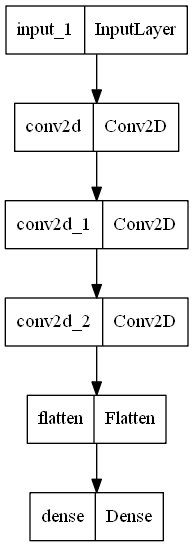

In [58]:
plot_model(model,to_file='base_line_model.png')

In [9]:
%load_ext tensorboard

In [60]:
clear_logs("model_1")
log_dir = "model_1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [61]:
%tensorboard --logdir model_1/fit

Reusing TensorBoard on port 6006 (pid 21908), started 3 days, 3:30:40 ago. (Use '!kill 21908' to kill it.)

In [62]:
base_model= model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[tensorboard_callback])

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,376,376] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1/Relu
 (defined at c:\ProgramData\Miniconda3\lib\site-packages\keras\backend.py:4867)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2797745]

Errors may have originated from an input operation.
Input Source operations connected to node model/conv2d_1/Relu:
In[0] model/conv2d_1/BiasAdd (defined at c:\ProgramData\Miniconda3\lib\site-packages\keras\layers\convolutional.py:264)

Operation defined at: (most recent call last)
>>>   File "c:\ProgramData\Miniconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Asus\AppData\Local\Temp\ipykernel_17004\2504899099.py", line 1, in <module>
>>>     base_model= model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[tensorboard_callback])
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\layers\convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "c:\ProgramData\Miniconda3\lib\site-packages\keras\backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 

In [16]:
tf.keras.backend.clear_session()
vgg = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(380,380,3))
vgg.trainable = False
batch_norm = BatchNormalization()
global_average_pool = GlobalAveragePooling2D()
dense1 = Dense(256, activation='relu')
dropout_layer = Dropout(0.5)
dense2 = Dense(128, activation='relu')
output =  Dense(120, activation='softmax')
model = tf.keras.models.Sequential([
    vgg,
    batch_norm,
    global_average_pool,
    dense1,
    dropout_layer,
    dense2,
    output
])

In [17]:
clear_logs("model_2")
log_dir = "model_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [13]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir model_2/fit

Reusing TensorBoard on port 6006 (pid 15640), started 3 days, 19:38:57 ago. (Use '!kill 15640' to kill it.)

In [19]:
vgg_log = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[early_stopping_callback, tensorboard_callback])

Epoch 1/40
230/230 [==============================] - 97s 420ms/step - loss: 4.5758 - accuracy: 0.0341 - val_loss: 4.2597 - val_accuracy: 0.0690
Epoch 2/40
230/230 [==============================] - 111s 481ms/step - loss: 3.7964 - accuracy: 0.1140 - val_loss: 3.4612 - val_accuracy: 0.1734
Epoch 3/40
230/230 [==============================] - 110s 480ms/step - loss: 3.2713 - accuracy: 0.1894 - val_loss: 3.1237 - val_accuracy: 0.2130
Epoch 4/40
230/230 [==============================] - 110s 477ms/step - loss: 2.9526 - accuracy: 0.2525 - val_loss: 2.9064 - val_accuracy: 0.2571
Epoch 5/40
230/230 [==============================] - 110s 478ms/step - loss: 2.7425 - accuracy: 0.2855 - val_loss: 2.8275 - val_accuracy: 0.2826
Epoch 6/40
230/230 [==============================] - 110s 480ms/step - loss: 2.5826 - accuracy: 0.3287 - val_loss: 2.7441 - val_accuracy: 0.3016
Epoch 7/40
230/230 [==============================] - 110s 480ms/step - loss: 2.4443 - accuracy: 0.3503 - val_loss: 2.6722 - 

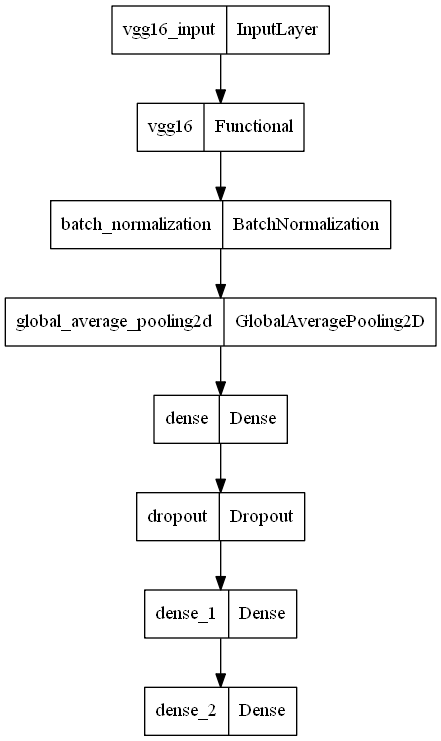

In [21]:
plot_model(model,to_file='vgg.png')

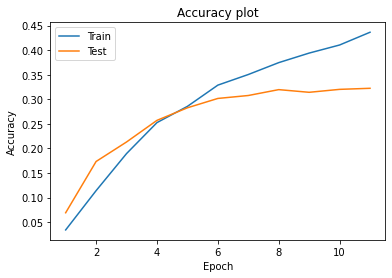

In [23]:
acc = vgg_log.history['accuracy']
val_acc = vgg_log.history['val_accuracy']
x_val = [i+1 for i in range(len(val_acc))]
plt.plot(x_val,acc, label="Train")
plt.plot(x_val,val_acc, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.show()

In [24]:
model.save("vgg.h5")

In [36]:
tf.keras.backend.clear_session()
inception = tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(380,380,3))
inception.trainable = False
batch_norm = BatchNormalization()
global_average_pool = GlobalAveragePooling2D()
dense1 = Dense(256, activation='relu')
dropout_layer = Dropout(0.5)
dense2 = Dense(128, activation='relu')
output =  Dense(120, activation='softmax')
model = tf.keras.models.Sequential([
    inception,
    batch_norm,
    global_average_pool,
    dense1,
    dropout_layer,
    dense2,
    output
])

In [37]:
clear_logs("model_3")
log_dir = "model_3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [38]:
%tensorboard --logdir model_3/fit

Reusing TensorBoard on port 6006 (pid 10068), started 3 days, 0:45:18 ago. (Use '!kill 10068' to kill it.)

In [39]:
inception_log = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[early_stopping_callback, tensorboard_callback])

Epoch 1/40
230/230 [==============================] - 120s 490ms/step - loss: 1.2320 - accuracy: 0.7536 - val_loss: 0.2786 - val_accuracy: 0.9228
Epoch 2/40
230/230 [==============================] - 116s 503ms/step - loss: 0.4183 - accuracy: 0.8916 - val_loss: 0.2888 - val_accuracy: 0.9207
Epoch 3/40
230/230 [==============================] - 122s 528ms/step - loss: 0.3446 - accuracy: 0.9035 - val_loss: 0.3198 - val_accuracy: 0.9152
Epoch 4/40
230/230 [==============================] - 125s 542ms/step - loss: 0.3349 - accuracy: 0.9015 - val_loss: 0.3288 - val_accuracy: 0.9147


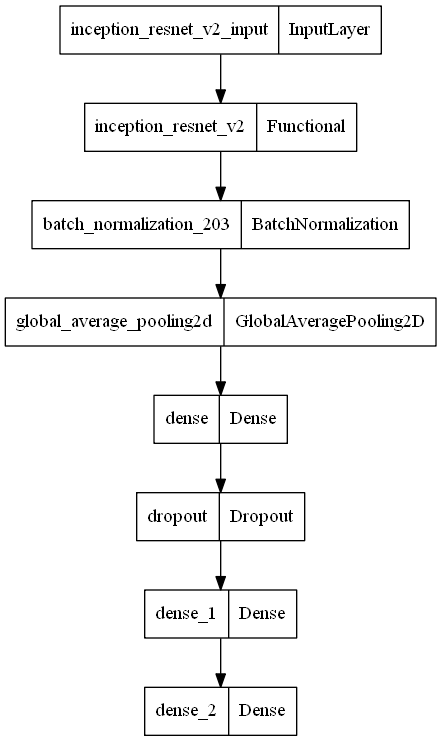

In [40]:
plot_model(model,to_file='inception.png')

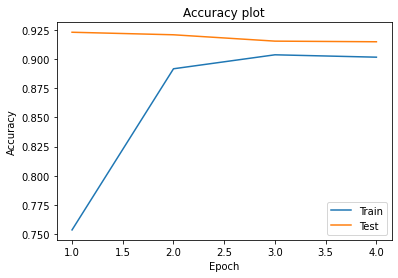

In [41]:
acc = inception_log.history['accuracy']
val_acc = inception_log.history['val_accuracy']
x_val = [i+1 for i in range(len(val_acc))]
plt.plot(x_val,acc, label="Train")
plt.plot(x_val,val_acc, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.show()

In [42]:
model.save("inception.h5")

In [17]:
tf.keras.backend.clear_session()
xception = tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=(380,380,3))
xception.trainable = False
batch_norm = BatchNormalization()
global_average_pool = GlobalAveragePooling2D()
dense1 = Dense(256, activation='relu')
dropout_layer = Dropout(0.5)
dense2 = Dense(128, activation='relu')
output =  Dense(120, activation='softmax')
model = tf.keras.models.Sequential([
    xception,
    batch_norm,
    global_average_pool,
    dense1,
    dropout_layer,
    dense2,
    output
])

In [18]:
clear_logs("model_4")
log_dir = "model_4/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [14]:
%load_ext tensorboard

In [19]:
%tensorboard --logdir model_4/fit

Reusing TensorBoard on port 6006 (pid 14208), started 4 days, 5:13:36 ago. (Use '!kill 14208' to kill it.)

In [20]:
xception_log = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[early_stopping_callback, tensorboard_callback])

c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/40
230/230 [==============================] - 160s 623ms/step - loss: 1.5167 - accuracy: 0.6542 - val_loss: 0.4126 - val_accuracy: 0.8804
Epoch 2/40
230/230 [==============================] - 156s 678ms/step - loss: 0.5031 - accuracy: 0.8473 - val_loss: 0.3377 - val_accuracy: 0.8967
Epoch 3/40
230/230 [==============================] - 150s 654ms/step - loss: 0.3974 - accuracy: 0.8751 - val_loss: 0.3649 - val_accuracy: 0.8946
Epoch 4/40
230/230 [==============================] - 151s 659ms/step - loss: 0.3492 - accuracy: 0.8940 - val_loss: 0.3470 - val_accuracy: 0.9033
Epoch 5/40
230/230 [==============================] - 140s 609ms/step - loss: 0.3016 - accuracy: 0.9024 - val_loss: 0.3403 - val_accuracy: 0.9016


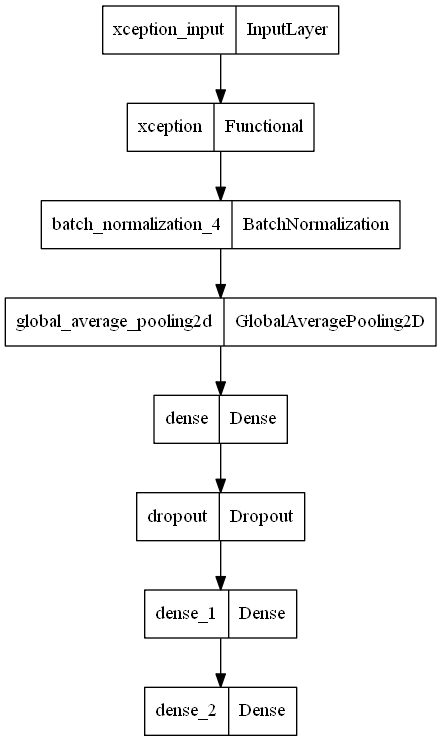

In [21]:
plot_model(model,to_file='xception.png') 

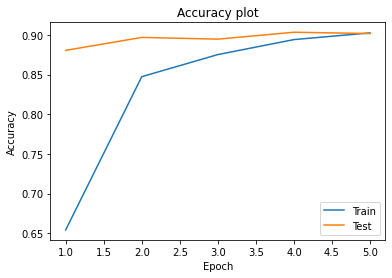

In [22]:
acc = xception_log.history['accuracy']
val_acc = xception_log.history['val_accuracy']
x_val = [i+1 for i in range(len(val_acc))]
plt.plot(x_val,acc, label="Train")
plt.plot(x_val,val_acc, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.show()

In [23]:
model.save("xception.h5")

Model /          Batch Size / Image Size / Epoch   Train Accuracy  Test Accuracy
Base Line Model / 32 / (380,380) / 10               Out of memory  Out of memory
VGG16 /         32 / (380,380) / 10                 37.45          31.96
InceptionResNet V2 / 32 / (380,380) / 10            90.15          91.47
Xception /  32 / (380,380) / 10                     91.66          90.76